In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from networkx.algorithms.community.quality import modularity
import networkx.algorithms.community as nx_comm
import scipy.stats as stats

In [2]:
datasets = ["cora", "chameleon", "cornell", "texas", "wisconsin"]
epochs = [0, 1, 2, 3, 4, 5, 10, 25, 50, 100]

def read_graph(path):
    df = pd.read_csv(path)
    g = nx.from_pandas_edgelist(df, edge_attr="weight")
    return g

def compute_modularity(graph, which="louvain"):
    if which == "louvain":
        comm = nx_comm.louvain_communities(graph, weight='weight', seed=42)
    else:
        comm = nx_comm.greedy_modularity_communities(graph, weight="weight")
    return round(modularity(graph, comm, weight='weight'),3)

def compute_jaccard(g0, g1, which="louvain"):
    if which == "louvain":
        partition_G0 = nx_comm.louvain_communities(g0, weight='weight', seed=42)
        partition_GNN = nx_comm.louvain_communities(g1, weight='weight', seed=42)
    else:
        partition_G0 = nx_comm.greedy_modularity_communities(g0, weight='weight')
        partition_GNN = nx_comm.greedy_modularity_communities(g1, weight='weight')
    #per ogni community della prima rete faccio jaccard con ogni community della seconda (da sistemare)
    overlap = 0
    n_overlap = 0
    for c1 in partition_G0:
        max_12 = 0
        if len(c1) > 2:
            for c2 in partition_GNN:
                j_12 = jaccard(c1, c2)
                if j_12 > max_12:
                    max_12 = j_12
            overlap += max_12
            n_overlap += 1
    if n_overlap == 0:
        max_jaccard = 0
    else:
        max_jaccard = overlap / n_overlap
    return max_jaccard

def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return round((float(intersection) / union),3)

In [3]:
data = {}
for n in epochs:
    data[n] = {}
    for d in datasets:
        if n == 0:
            data[n][d] = read_graph(d + "/" + d + "_cosine_weights.csv")
            for n1, n2 in data[n][d].edges:
                data[n][d][n1][n2]["weight"] = 1
        elif n == 1500:
            data[n][d] = read_graph(d + "/" + d + "_cosine_weights.csv")
        else:
            data[n][d] = read_graph(d + "/" + d + "_cosine_weights" + str(n) + ".csv")

## COMMUNITY

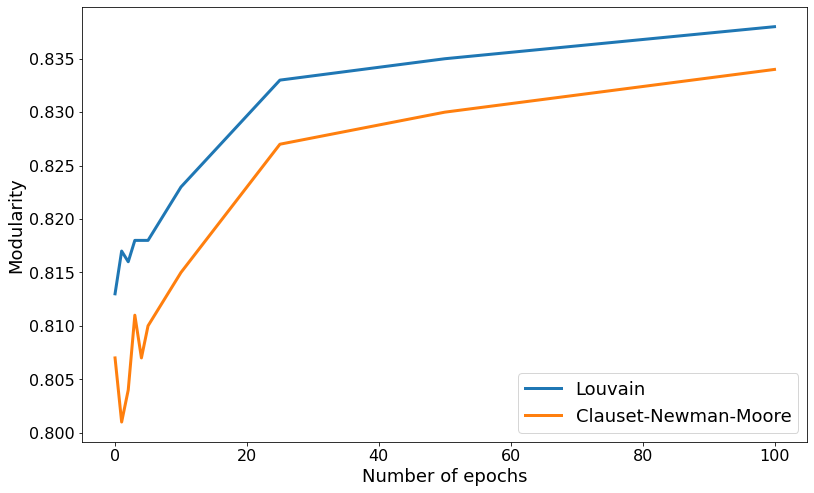

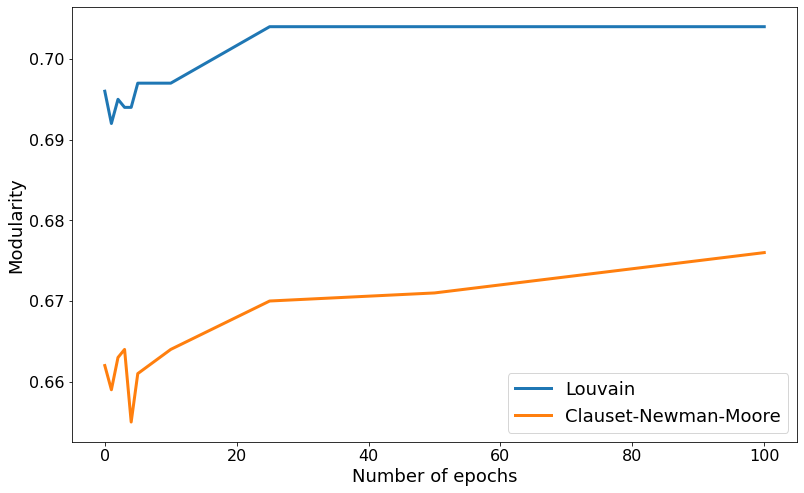

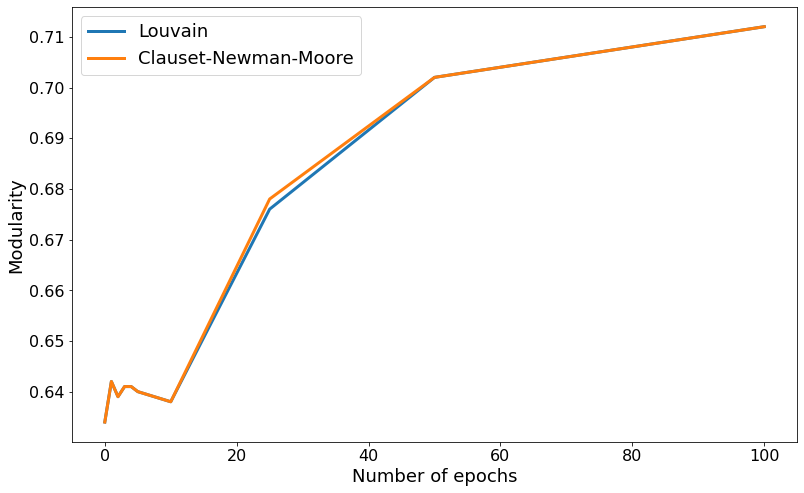

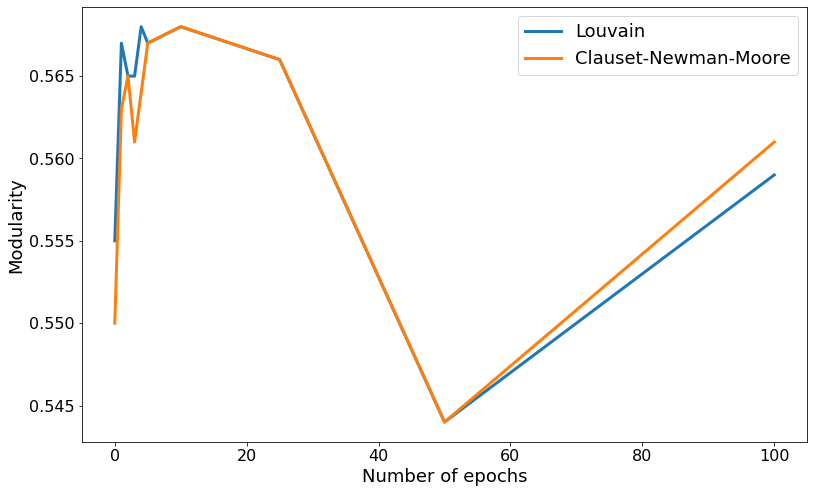

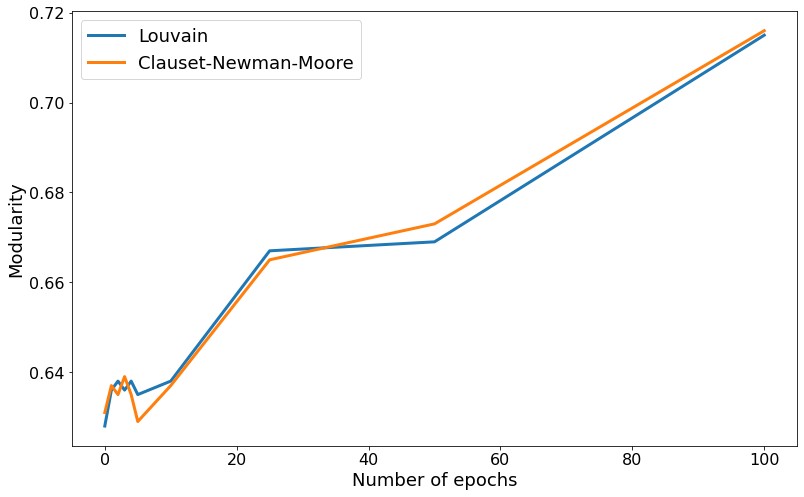

In [4]:
distribution_louvain = {}
distribution_greedy = {}
for d in datasets:
    for e in epochs:
        distribution_louvain[e] = compute_modularity(data[e][d], which="louvain")
        distribution_greedy[e] = compute_modularity(data[e][d], which="greedy")
    plt.figure(figsize=(13,8))
    plt.plot(list(distribution_louvain.keys()), list(distribution_louvain.values()),linewidth=3)
    plt.plot(list(distribution_greedy.keys()), list(distribution_greedy.values()),linewidth=3)
    plt.xlabel("Number of epochs", fontsize=18)
    plt.ylabel("Modularity", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(["Louvain", "Clauset-Newman-Moore"], fontsize=18)
    plt.savefig("plots/" + d.capitalize() + "-modularity.pdf", dpi=100, bbox_inches='tight')

## JACCARD

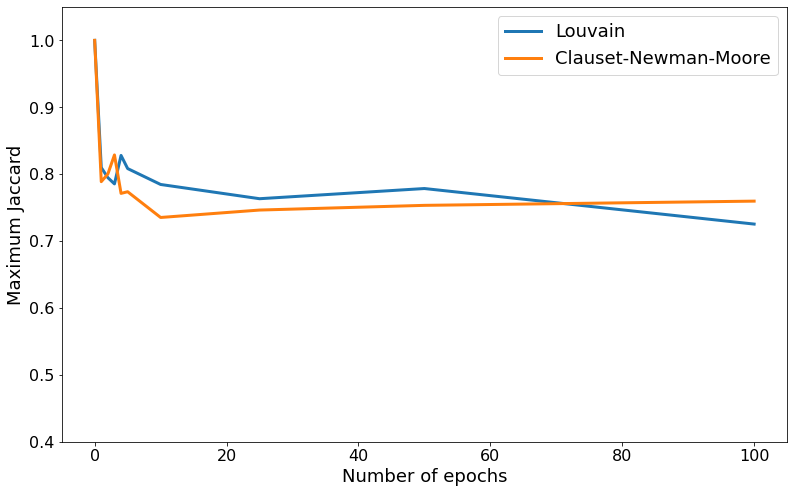

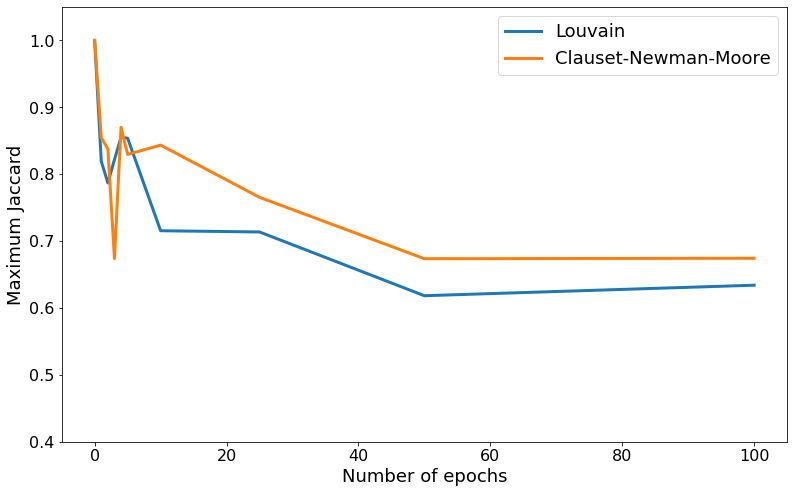

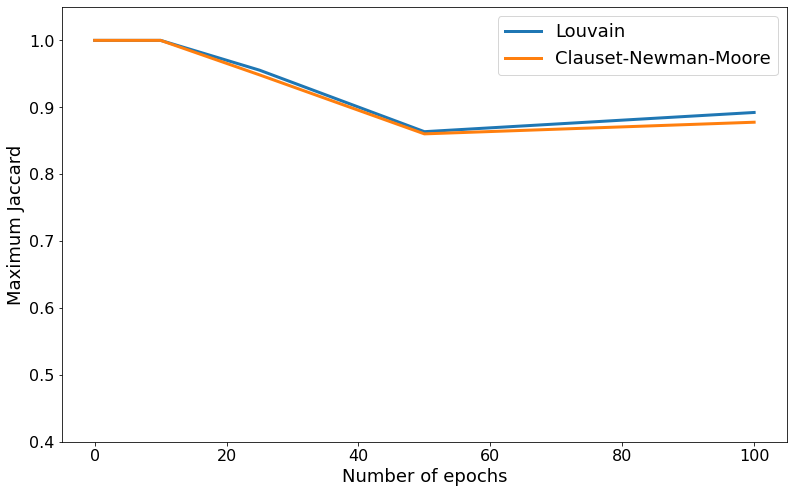

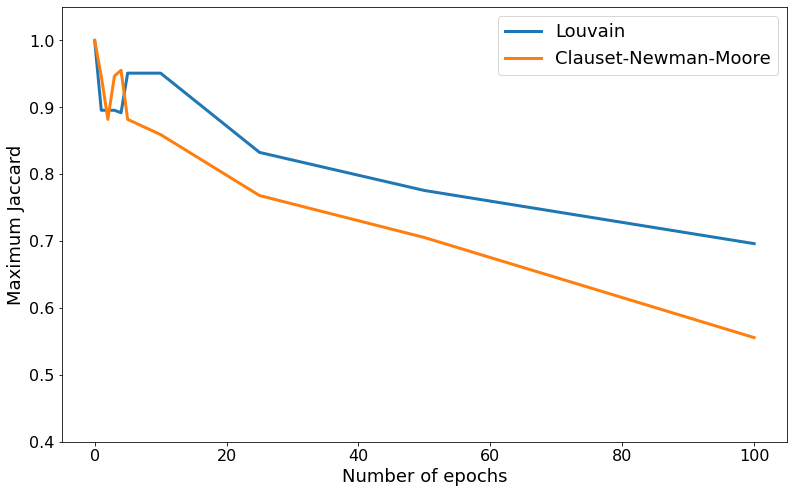

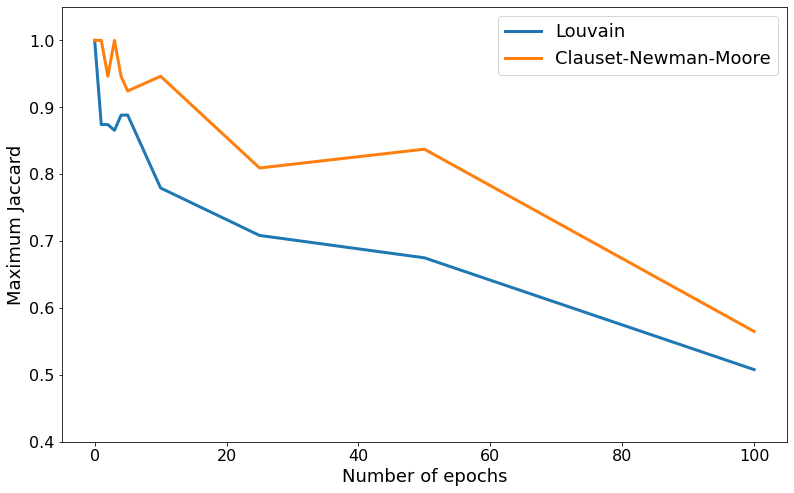

In [10]:
distribution_louvain = {}
distribution_greedy = {}

for d in datasets:
    for e in epochs:
        distribution_louvain[e] = compute_jaccard(data[0][d], data[e][d], which="louvain")
        distribution_greedy[e] = compute_jaccard(data[0][d], data[e][d], which="greedy")
    
    plt.figure(figsize=(13,8))
    plt.plot(list(distribution_louvain.keys()), list(distribution_louvain.values()),linewidth=3)
    plt.plot(list(distribution_greedy.keys()), list(distribution_greedy.values()),linewidth=3)
    plt.xlabel("Number of epochs", fontsize=18)
    plt.ylabel("Maximum Jaccard", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim((0.4, 1.05))
    plt.legend(["Louvain", "Clauset-Newman-Moore"], fontsize=18)
    plt.savefig("plots/" + d.capitalize() + "-jaccard.pdf", dpi=100, bbox_inches='tight')

## CLUSTERING

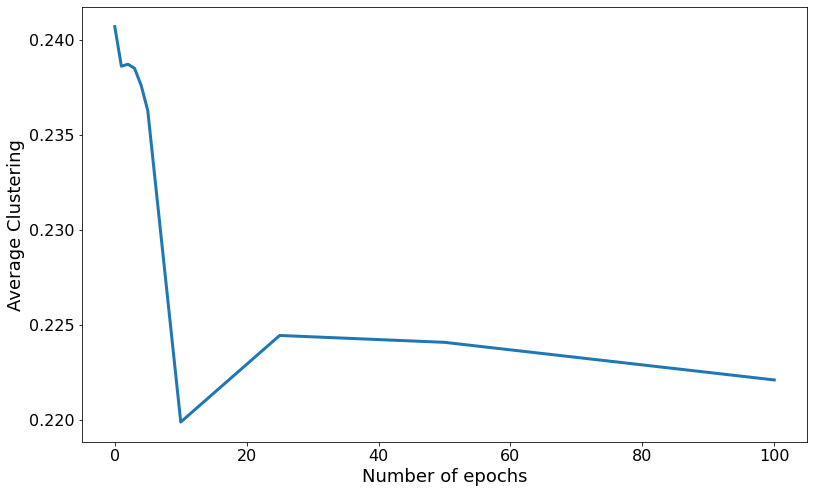

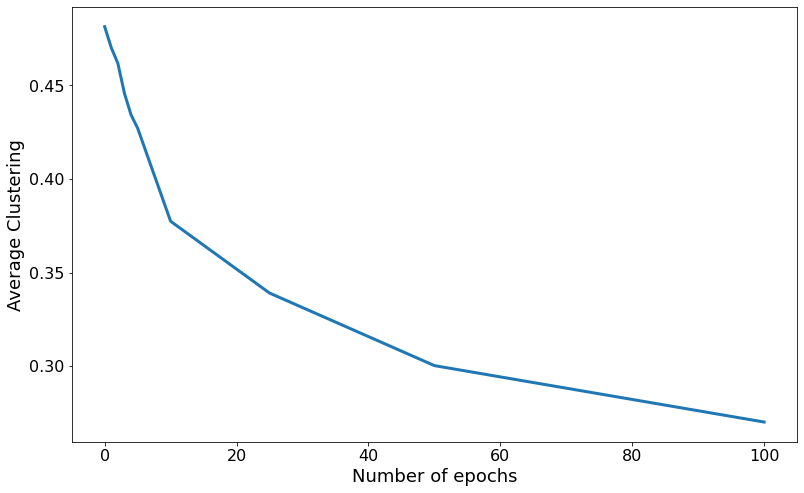

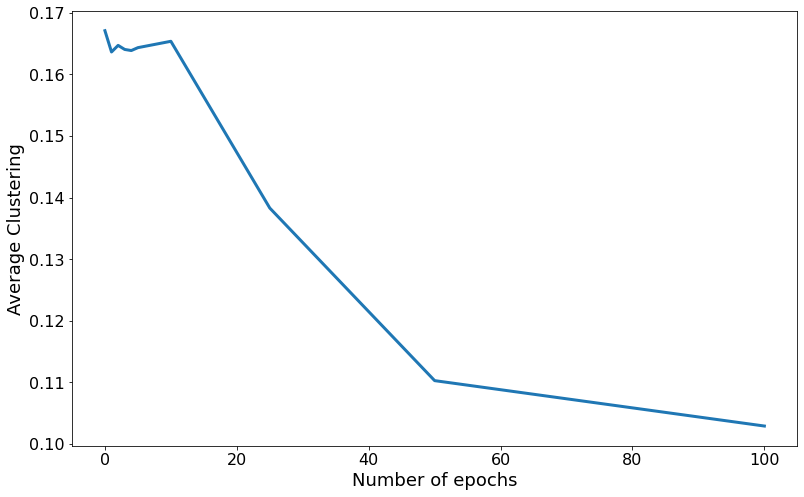

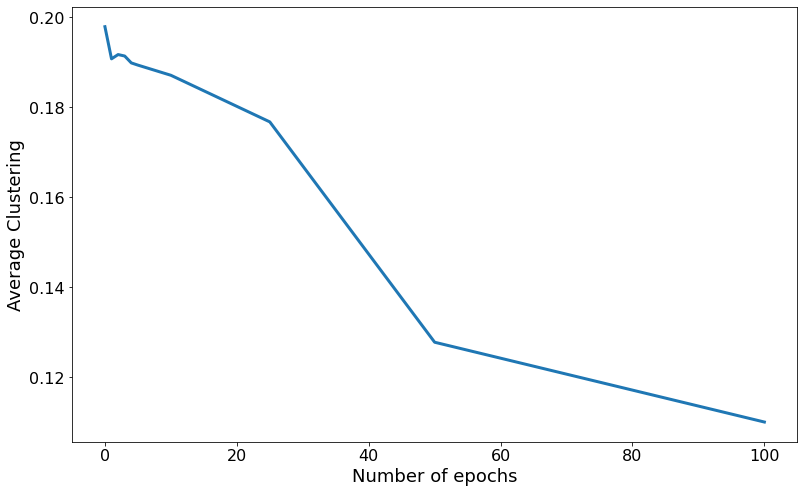

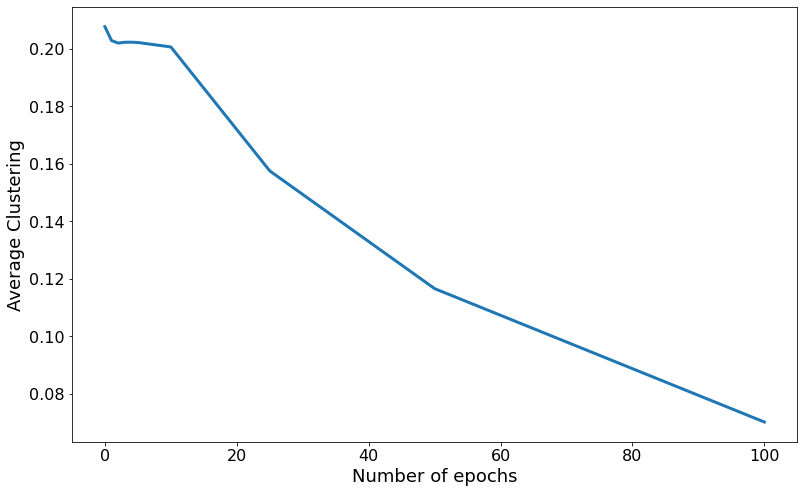

In [6]:
distribution = {}

for d in datasets:
    for e in epochs:
        distribution[e] = nx.average_clustering(data[e][d], weight = 'weight')
    
    plt.figure(figsize=(13,8))
    plt.plot(list(distribution.keys()), list(distribution.values()),linewidth=3)
    plt.xlabel("Number of epochs", fontsize=18)
    plt.ylabel("Average Clustering", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig("plots/" + d.capitalize() + "-clustering.pdf", dpi=100, bbox_inches='tight')

## DEGREE

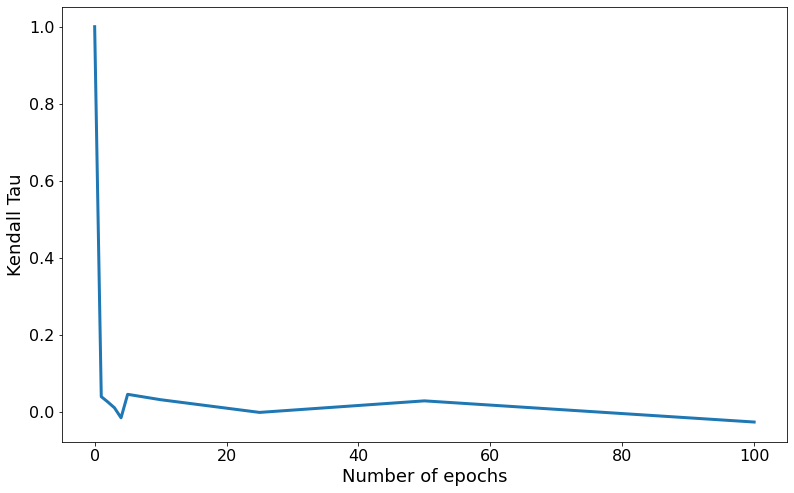

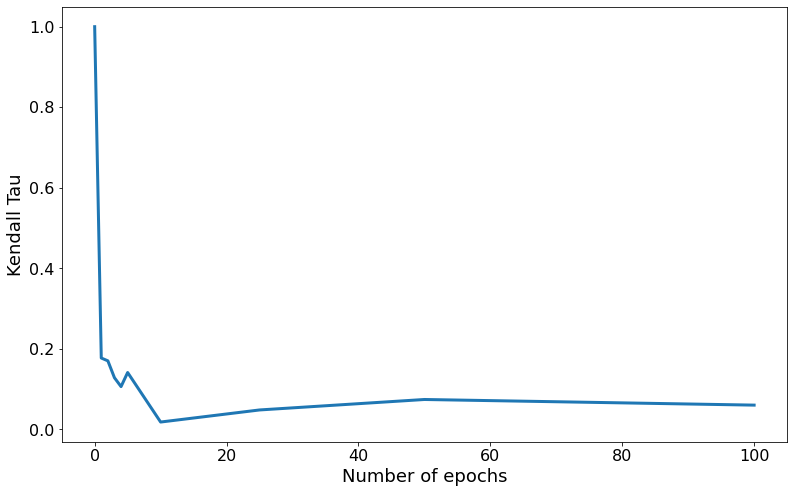

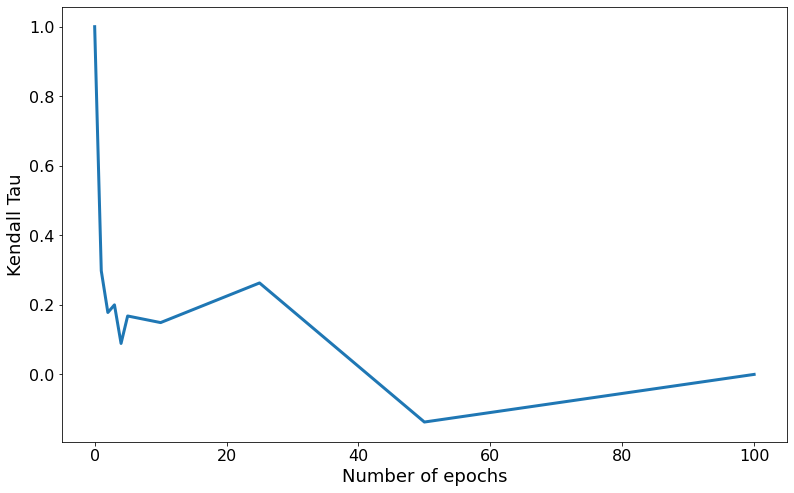

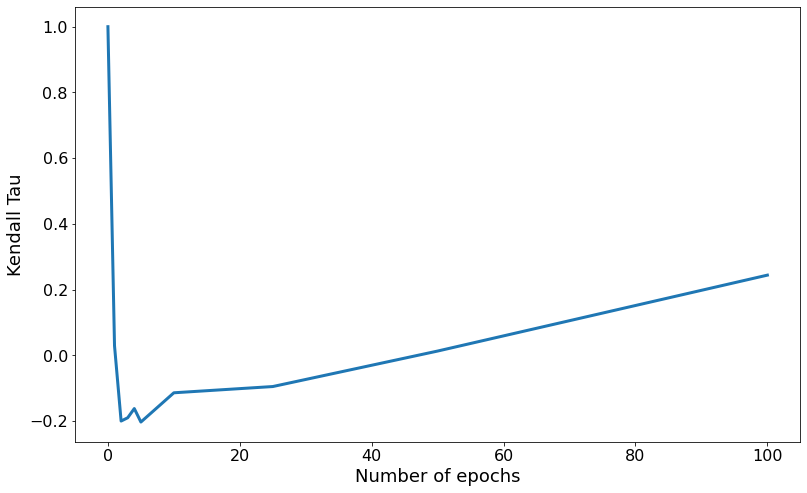

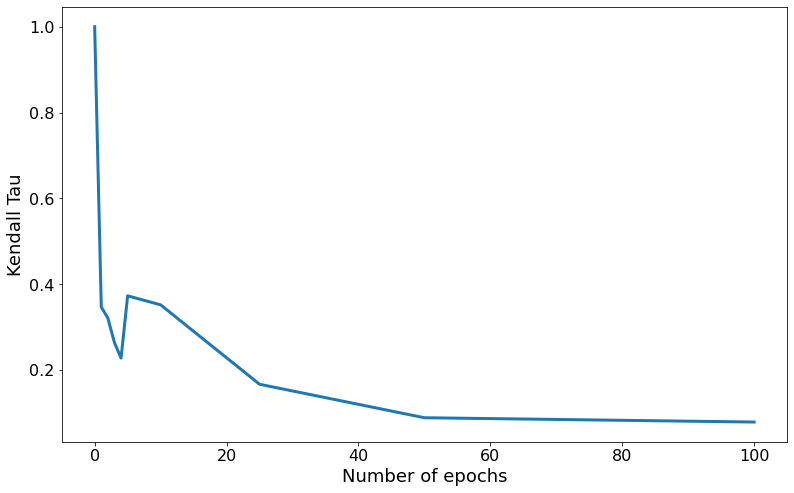

In [7]:
def K_tau(dict1,dict2):
    sorted_dict1 = dict(sorted(dict1.items(), key=lambda item: item[1],reverse=True))
    sorted_dict2 = dict(sorted(dict2.items(), key=lambda item: item[1],reverse=True))
    x1 = list(sorted_dict1.keys())[:int(len(dict1)*0.2)]
    x2 = list(sorted_dict2.keys())[:int(len(dict1)*0.2)]
    tau, p_value = stats.kendalltau(x1, x2)
    return round(tau,3)

def all_K_tau(G0, G_sim):
    degree_G0 = dict(G0.degree(weight="weight"))
    degree_Gsim = dict(G_sim.degree(weight="weight"))
    return K_tau(degree_G0, degree_Gsim)

distribution = {}

for d in datasets:
    for e in epochs:
        distribution[e] = all_K_tau(data[0][d], data[e][d])
    
    plt.figure(figsize=(13,8))
    plt.plot(list(distribution.keys()), list(distribution.values()),linewidth=3)
    plt.xlabel("Number of epochs", fontsize=18)
    plt.ylabel("Kendall Tau", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig("plots/" + d.capitalize() + "-degree.pdf", dpi=100, bbox_inches='tight')